In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

%pylab inline

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
text_name = 'good_pulses.txt'
with open(text_name, 'r') as f:
    text = f.read()
    text_lines = text.split('\n')

i = 235
nchan = 512
tele1 = 'jb'
tele2 = 'ef'
time_string1 = '2015-10-19T00:17:47.415' # S/N = 89!, main pulse 
time_string2 = '2015-10-19T02:35:26.143' # S/N = 43, main pulse 
time_string3 = '2015-10-19T02:06:52.280' #S/N = 7.9, inter pulse
time_string4 = '2015-10-19T02:06:58.031' #S/N = 9.6, main pulse

In [83]:
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:5]) 
    noise_mean = np.mean(outputsumfreq[:5])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
#     print 'standard deviation of noise is ', noise_std, 'the mean noise is ', noise_mean
    return sigs_noise

def load_gp(time_string,telescope,nchan,draw = 0):
    '''Takes in a time string, a string indicating whcih telescope to use, and an interger of nchan'''
    gp1 = np.load('/home/ramain/GPs/GP{}/p{}.npy'.format(telescope,time_string))
    gp1t = np.fft.irfft(gp1,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T


    outputsumfreq = output.sum(0) #dedispersed
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    
    S_N = max(sigs_noise)
    peak_time = np.argmax(sigs_noise)
    figure()
    plot(sigs_noise)
    
    if nchan ==512:
        background_freq = (output[:,peak_time-1]+output[:,peak_time+1])/2
        output_pulse = output[:,peak_time]

    freq_spec = output_pulse-background_freq
#     freq_spec = output_pulse
    figure()
    plot(output_pulse)
    plot(background_freq)
    
    if draw:
        figure(figsize = (10,3))
        plot(outputsumfreq)
    return freq_spec,background_freq

In [37]:
def process_freq_spec(gp1,nchan,index=None,draw=0,normalized = 0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, divide by the giant pulse mean, and normalize it by itself gp1=freq_spec[i]. function also plots the frequency spectrum'''
    gp1_8=np.array([gp1[int(40./512*nchan):int(465./512*nchan)]])
    for j in range(7):gp1_8=np.append(gp1_8,np.array([gp1[(j+1)*(nchan+1)+int(40./512*nchan):(j+1)*(nchan+1)+int(465./512*nchan)]]),0)
#     gp1_8/=gpab #Dividing by giant pulse average
    if normalized:
        for i in range(8):gp1_8[i]=gp1_8[i]/gp1_8[i].mean()-1.
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))

        for i in range(8):axarr[i].plot(gp1_8[i])
        axarr[0].set_title('Frequency spectrum of giant pulse at {}'.format(time_values[index]))
    return gp1_8

std of noise is  10051.9809915
the two pulses are 1.00002350614 correlated
[1.0000661895175436, 0.99973319115528325, 1.0000927240452571, 1.0001689443208681, 1.0003843533921271, 1.0000218640291603, 1.0001079888181688, 0.99961279383133417]
(8, 425)
mean of pulse is [ 170375.69715979  143592.48947659  125408.28124357  125615.19980175
  114438.9607004   113034.22578476  154561.34718768  120340.04528726]
std of noise1 is  [ 10329.33368364   9863.82838891  10320.60136863   9655.74465677
  10023.53604155   9822.00509632  10125.95271759   9794.04591947]
std of pulse1 is  [ 123283.34356618  105412.41457648   94005.41756403  109877.46425211
   86604.82755713   86967.12892262  115789.70768669   85338.174192  ]
std of noise2 is  [ 10546.74206285   9772.89920493  10110.42668751  10048.22541436
   9581.45215739   9804.08155367   9820.26534323  10163.30731156]
std of pulse2 is  [ 123276.73072171  104705.75661386   92539.72595421  109340.7469777
   86802.93007929   87768.22587374  115915.97484279   86

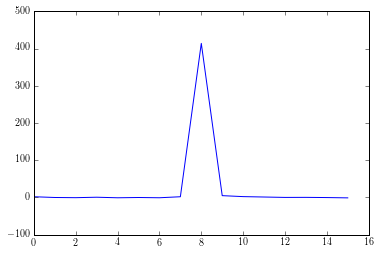

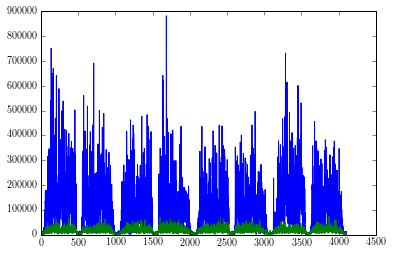

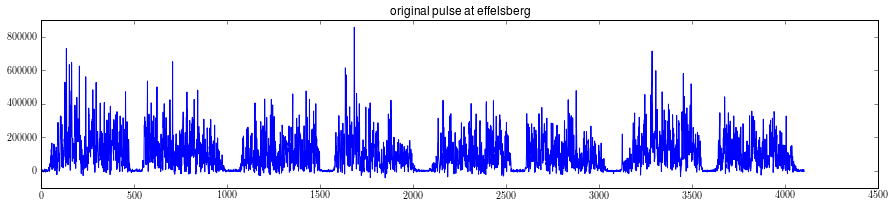

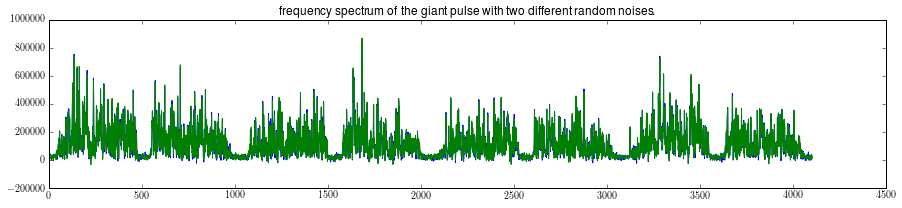

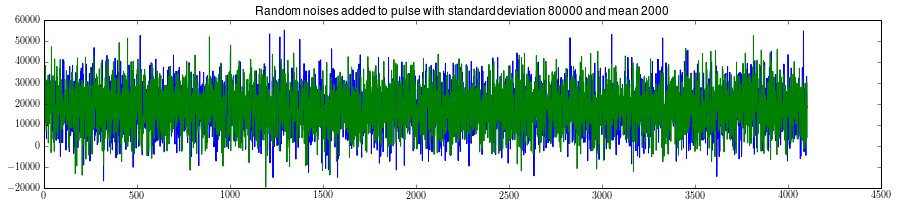

In [85]:
def get_cc((fs1,fs1bg),(fs2,fs2bg)):
    mean1 = np.mean(fs1)
    mean2 = np.mean(fs2)
    numerator = np.mean((fs1-mean1)*(fs2-mean2))
    denominator = np.sqrt(((np.std(fs1))**2-(np.std(fs1bg))**2)*((np.std(fs2))**2-(np.std(fs2bg))**2))
#     denominator = np.std(fs1)*np.std(fs2)
    return numerator/denominator
    
def get_ccs((fs1,fs1bg),(fs2,fs2bg)):
    coefficients= []
    for i in range(8):
        X = fs1[i]
        Y = fs2[i]
        Xbg = fs1bg[i]
        Ybg = fs2bg[i]
#         coefficient = np.corrcoef(X,Y)[0,1] # np.corrcoef returns a matrix [1, coeff;coeff,1] 
        coefficient = get_cc((X,Xbg),(Y,Ybg))
        coefficients.append(coefficient) 
    return np.mean(coefficients),coefficients

noise1 = np.random.normal(18000.,10000,4104)
noise2 = np.random.normal(18000.,10000,4104)

gp1,gp1bg = load_gp(time_string1,tele1,nchan)
gp2 = gp1.copy()

figure(figsize=(15,3))
plot(gp1)
title('original pulse at effelsberg')

gp1 = gp1+noise1
gp2+=noise2

figure(figsize = (15,3))
plot(gp1)
plot(gp2)
title('frequency spectrum of the giant pulse with two different random noises.')

figure(figsize = (15,3))
plot(noise1)
plot(noise2)
title('Random noises added to pulse with standard deviation 80000 and mean 2000')

print 'std of noise is ', np.std(noise1,axis = 0)
gp1 = process_freq_spec(gp1,nchan,i-1,draw = 0,normalized = 0)
noise1 = process_freq_spec(noise1,nchan,i-1,draw = 0)
gp2 = process_freq_spec(gp2,nchan,i-1,draw = 0, normalized = 0)
noise2 = process_freq_spec(noise2,nchan,i-1,draw = 0)

cc,ccs = get_ccs((gp1,noise1),(gp2,noise2))

# np.corrcoef(gp1,gp2)[0,1]
print 'the two pulses are', cc ,'correlated'
print ccs

print noise1.shape

print 'mean of pulse is', np.mean(gp1,axis = 1)
print 'std of noise1 is ', np.std(noise1,axis = 1)
print 'std of pulse1 is ', np.std(gp1,axis = 1)

print 'std of noise2 is ', np.std(noise2,axis = 1)
print 'std of pulse2 is ', np.std(gp2,axis = 1)

In [55]:
def bin_data(t,a,bins):
    '''This function takes in t( an array of time values), a (array of data), and the bins and return an array of the binned data a'''
    a_binned = np.histogram(t,bins,weights = a,density = False)[0]/np.histogram(t,bins,density = False)[0]
    return a_binned 

def transform_to_timelag(fgp,index= None,draw = 0,binned=0,normalized = 0):
    if binned ==0:
        N = 213
#         tgp=np.zeros(shape=(0,N))
#         print np.array
#         for i in range(8):tgp=np.append(tgp,np.array([np.fft.rfft(fgp[i])]),0)
        #normalize it:
        if normalized:
            fgpn = np.zeros_like(fgp)
            for i in range(8):fgpn[i]=fgp[i]/np.mean(fgp[i])-1.
            print fgp.shape
            tgp = np.fft.rfft(fgpn,axis = 1)
        else:
            tgp = np.fft.rfft(fgp,axis = 1)
    else:
        N = 15
        tgp = np.zeros(shape=(0,N))
        for i in range(8):
            if normalized:
                a = np.fft.rfft(fgp[i]/fpg[i].mean()-1.)
            else:
                a = np.fft.rfft(fgp[i])
            tgp=np.append(tgp,np.array([bin_data(np.linspace(0,15,213),abs(a),np.linspace(0,15,16))]),0)    
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))
        for i in range(8):axarr[i].plot(np.linspace(0,15,N),abs(tgp[i]))
#         axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
        axarr[7].set_xlabel('Time lag(\mu s)')
    return tgp


(8, 425)
(8, 425)
(8, 425)
(8, 213)
(8, 425)
(8, 425)


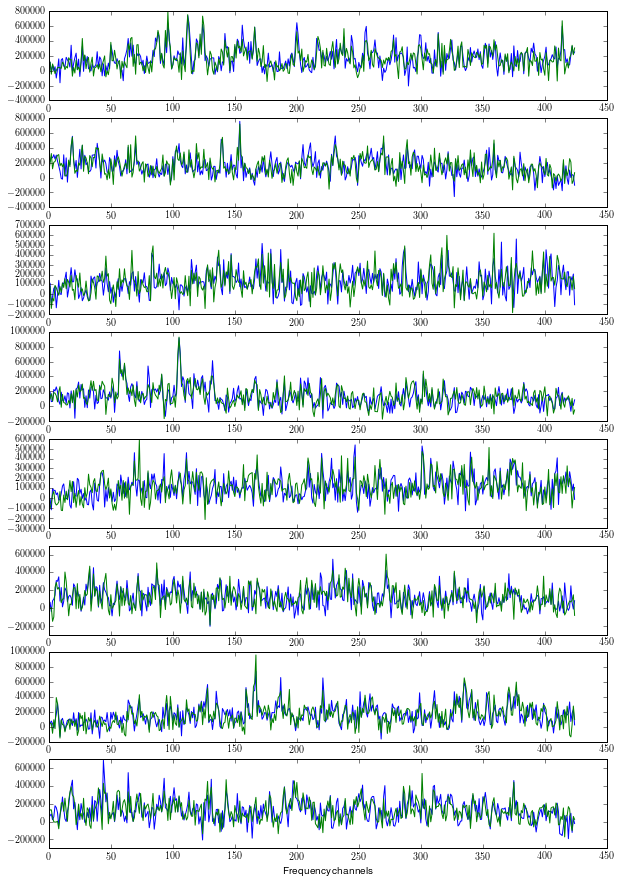

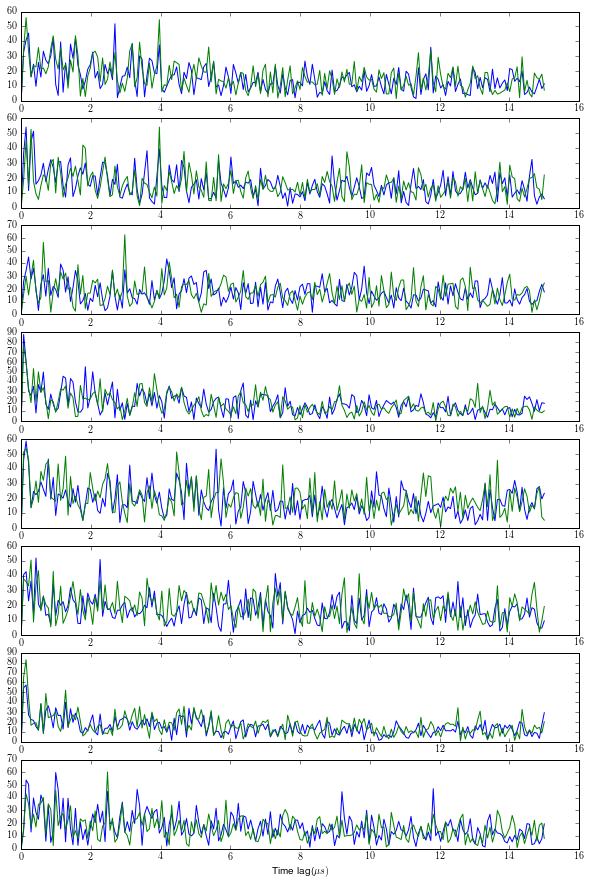

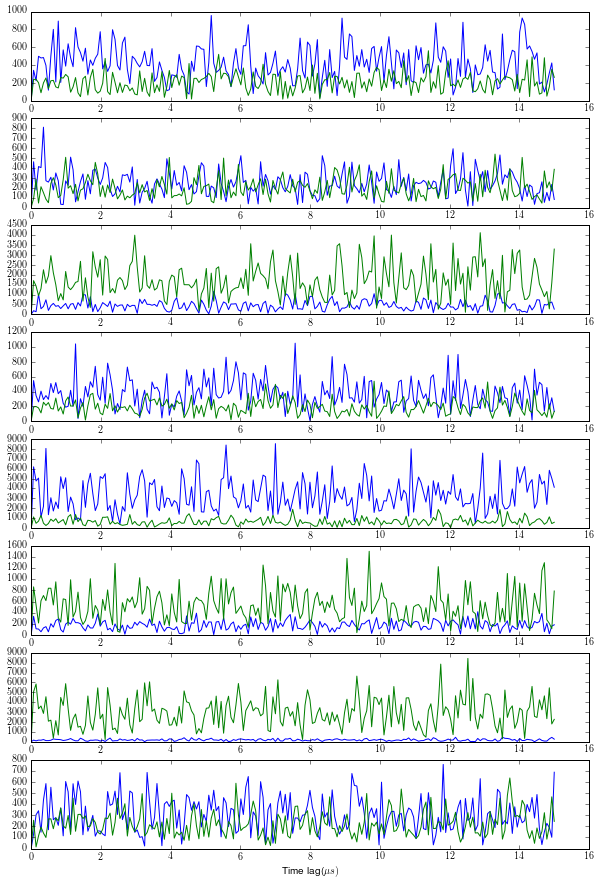

In [62]:
print gp1.shape
tgp1=transform_to_timelag(gp1,draw = 0,binned = 0,normalized = 1)
tgp1bg = transform_to_timelag(noise1,draw = 0,binned = 0,normalized = 1)
print tgp1.shape
tgp2=transform_to_timelag(gp2,draw = 0, binned = 0,normalized = 1)
tgp2bg=transform_to_timelag(noise2,draw = 0, binned = 0,normalized = 1) 

N = 213
f,axarr=plt.subplots(8,1,figsize=(10,15))
for i in range(8):
    axarr[i].plot(gp1[i])
    axarr[i].plot(gp2[i])
#         axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
axarr[7].set_xlabel('Frequency channels')

f,axarr=plt.subplots(8,1,figsize=(10,15))
for i in range(8):
    axarr[i].plot(np.linspace(0,15,N),abs(tgp1[i]))
    axarr[i].plot(np.linspace(0,15,N),abs(tgp2[i]))
#         axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
axarr[7].set_xlabel('Time lag(\mu s)')

f,axarr=plt.subplots(8,1,figsize=(10,15))
for i in range(8):
    axarr[i].plot(np.linspace(0,15,N),abs(tgp1bg[i]))
    axarr[i].plot(np.linspace(0,15,N),abs(tgp2bg[i]))
#         axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
axarr[7].set_xlabel('Time lag(\mu s)')

In [24]:
def find_cc((fs1,fs1bg),(fs2,fs2bg), binned = 0, bin_no=16):
    '''This find_cc function uses Robert\'s .npy pulses, with a different bg noise for each pulse''' 
    print fs1.shape
    tgp1=transform_to_timelag(fs1,draw = 0,binned = 0)
    tgp1bg = transform_to_timelag(fs1bg,draw = 0,binned = 0)
    print tgp1.shape
    tgp2=transform_to_timelag(fs2,draw = 0, binned = 0)
    tgp2bg=transform_to_timelag(fs2bg,draw = 0, binned = 0) 
    
    time_lag_values = np.linspace(0,15,213)
    if binned:
#         bins = np.logspace(np.log10(time_lag_values[1]),np.log10(15),bin_no)
        bins = np.linspace(0,15,bin_no)
        numerator_8 = np.zeros(shape = (0,bin_no-1))
    else:
        numerator_8 = np.zeros(shape = (0,213))
        
    for k in range(8):
        if binned:
            numerator = np.real(tgp1[k]*np.conj(tgp2[k]))
            numerator_8 = np.append(numerator_8,np.array([bin_data(time_lag_values,numerator,bins)]),0)
        else:
            numerator_8 = np.append(numerator_8,np.array([tgp1[k]*np.conj(tgp2[k])]),0)
    
    bgstd1=find_std(tgp1bg)
    bgstd2=find_std(tgp2bg)
#     print bgstd1[:10]
#     print bgstd2[:10]
    numerator = numerator_8.mean(0)
     
#     tgp1b = np.zeros(shape = (0,bin_no-1))
#     tgp2b = np.zeros(shape = (0,bin_no-1))
#     for k in range(8):
#         tgp1b = np.append(tgp1b,np.array([bin_data(time_lag_values,tgp1[k],bins)]),0)
#         tgp2b = np.append(tgp2b,np.array([bin_data(time_lag_values,tgp2[k],bins)]),0)
    
#     denominator = np.std(tgp1b)*np.std(tgp2b)
    
#     The old method of getting standard deviation
    stdgp1 = find_std(tgp1)
    print 'tgp1 has type', tgp1.dtype
    print 'stdgp1 has type',stdgp1.dtype
    stdgp2 = find_std(tgp2)
    if binned:
        stdgp1b = bin_data(time_lag_values,stdgp1,bins)
        stdgp2b = bin_data(time_lag_values,stdgp2,bins)
        bgstd1b = bin_data(time_lag_values,bgstd1,bins)
        bgstd2b = bin_data(time_lag_values,bgstd2,bins)
        denominator = np.sqrt((stdgp1b**2-bgstd1b**2)*(stdgp2b**2-bgstd2b**2))
#         denominator = stdgp1b*stdgp2b
#         denominator = bin_data(time_lag_values,np.std((tgp1*np.conj(tgp2)),axis=0),bins)
    else:
        denominator = np.sqrt((stdgp1**2-bgstd1**2)*(stdgp2**2-bgstd2**2))
#         denominator = stdgp1*stdgp2
#         denominator = np.std((tgp1*np.conj(tgp2)),axis=0)


    cc = numerator/denominator
    figure()
    if binned:
        plot(bins[:-1],denominator,label = 'denominator')
        plot(bins[:-1], numerator, label = 'numerator')
    else:
        plot(time_lag_values, numerator, label = 'numerator')
        plot(time_lag_values,denominator,label = 'denominator')
#     print 'denominator is ',denominator
#     title('Numerator and denominator of cc between {} {}'.format(tele1,))
    legend()
    return cc

(8, 425)
(8, 213)
tgp1 has type complex128
stdgp1 has type float64


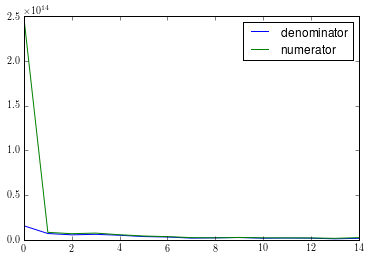

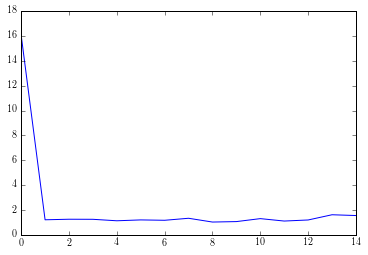

In [63]:
ccnoisetest = find_cc((gp1,noise1),(gp2,noise2),binned = 1)
figure()
plot(ccnoisetest)